In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/CV_Project
!unzip -q final_project_optimized.zip
%cd "FINAL PROJECT"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/CV_Project
replace FINAL PROJECT/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
/content/drive/MyDrive/Colab Notebooks/CV_Project/FINAL PROJECT


In [2]:
import kagglehub
dataset_path = kagglehub.dataset_download("adlteam/kaist-dataset")
print(f"Dataset: {dataset_path}")

Using Colab cache for faster access to the 'kaist-dataset' dataset.
Dataset: /kaggle/input/kaist-dataset


In [3]:
#Create proper directory structure and link dataset
import os
import shutil

# Navigate to project root
%cd /content/drive/MyDrive/Colab\ Notebooks/CV_Project/FINAL\ PROJECT

# Create data directory structure
!mkdir -p data/kaist/raw

# Create symbolic link to downloaded dataset
dataset_path = "/kaggle/input/kaist-dataset"
!ln -s {dataset_path} data/kaist/raw/kaist-dataset

# Verify structure
print("✓ Directory structure created!")
print("\nProject structure:")
!tree -L 3 -d . 2>/dev/null || find . -type d -maxdepth 3

print("\nDataset location:")
!ls -la data/kaist/raw/

/content/drive/MyDrive/Colab Notebooks/CV_Project/FINAL PROJECT
ln: failed to create symbolic link 'data/kaist/raw/kaist-dataset/kaist-dataset': Read-only file system
✓ Directory structure created!

Project structure:
find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
.
./experiments
./experiments/baseline_rgb
./experiments/baseline_thermal
./experiments/early_fusion
./experiments/mid_fusion
./configs
./data
./data/flir
./data/flir/annotations
./data/flir/processed
./data/flir/raw
./data/kaist
./data/kaist/annotations
./data/kaist/processed
./data/kaist/raw
./data/llvip
./data/llvip/annotations
./data/llvip/processed
./data/llvip/raw
./low_light_pedestrian_risk_detection.egg-info
./scripts
./src
./src/utils
./src/utils/__pycache__
./src/__pycache__
./venv
./venv/Include
.

In [4]:
#Verify dataset is accessible
import os

# Check dataset
dataset_root = "/kaggle/input/kaist-dataset"
print(f"Dataset path: {dataset_root}")
print(f"Exists: {os.path.exists(dataset_root)}")

# List sets
sets = sorted([d for d in os.listdir(dataset_root) if d.startswith('set')])
print(f"\nAvailable sets: {sets}")

# Check set00 structure
set00_path = os.path.join(dataset_root, 'set00')
videos = sorted([d for d in os.listdir(set00_path) if d.startswith('V')])
print(f"\nVideos in set00: {videos[:5]}... ({len(videos)} total)")

# Check one video folder
v000_path = os.path.join(set00_path, 'V000')
print(f"\nV000 contents:")
!ls -la {v000_path}

print("\n✓ Dataset is properly organized!")

Dataset path: /kaggle/input/kaist-dataset
Exists: True

Available sets: ['set00', 'set01', 'set02', 'set03', 'set04', 'set05']

Videos in set00: ['V000', 'V001', 'V002', 'V003', 'V004']... (9 total)

V000 contents:
total 0
drwxr-sr-x  4 1000 1000 0 Dec  6 13:58 .
drwxr-sr-x 11 1000 1000 0 Dec  6 14:01 ..
drwxr-sr-x  2 1000 1000 0 Dec  6 13:58 lwir
drwxr-sr-x  2 1000 1000 0 Dec  6 13:59 visible

✓ Dataset is properly organized!


In [5]:
#Update paths in code to use correct dataset location
import sys

# Add project to path
project_root = "/content/drive/MyDrive/Colab Notebooks/CV_Project/FINAL PROJECT"
sys.path.insert(0, project_root)

# Set dataset path as environment variable for easy access
os.environ['DATASET_PATH'] = '/kaggle/input/kaist-dataset'

print(f"✓ Project root: {project_root}")
print(f"✓ Dataset path: {os.environ['DATASET_PATH']}")

✓ Project root: /content/drive/MyDrive/Colab Notebooks/CV_Project/FINAL PROJECT
✓ Dataset path: /kaggle/input/kaist-dataset


In [9]:
# Cell: All-in-one training code
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
import os
from pathlib import Path
import numpy as np

# Model
class FastPedestrianDetector(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        self.rgb_backbone = mobilenet_v3_small(weights=weights)
        self.thermal_backbone = mobilenet_v3_small(weights=None)

        if pretrained:
            self.thermal_backbone.load_state_dict(self.rgb_backbone.state_dict())
            old_conv = self.thermal_backbone.features[0][0]
            self.thermal_backbone.features[0][0] = nn.Conv2d(
                1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                stride=old_conv.stride, padding=old_conv.padding, bias=False
            )

        self.rgb_features = nn.Sequential(*list(self.rgb_backbone.features))
        self.thermal_features = nn.Sequential(*list(self.thermal_backbone.features))

        self.fusion = nn.Sequential(
            nn.Conv2d(576 * 2, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.detection_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes + 4, kernel_size=1)
        )

    def forward(self, images):
        rgb_feat = self.rgb_features(images['rgb'])
        thermal_feat = self.thermal_features(images['thermal'])
        fused = torch.cat([rgb_feat, thermal_feat], dim=1)
        fused = self.fusion(fused)
        detections = self.detection_head(fused)
        return {'detections': detections}

# Dataset
class FastKAISTDataset(Dataset):
    def __init__(self, root_dir, subset='set00', split='train', image_size=(320, 240), augment=True):
        self.root_dir = Path(root_dir)
        self.image_size = image_size
        self.augment = augment and (split == 'train')
        self.samples = self._load_samples(subset)
        self._split_data(split)
        self.rgb_transform = self._get_rgb_transform()
        self.thermal_transform = self._get_thermal_transform()

    def _load_samples(self, subset):
        samples = []
        subset_path = self.root_dir / subset
        for video_dir in sorted(subset_path.glob('V*')):
            rgb_dir = video_dir / 'visible'
            thermal_dir = video_dir / 'lwir'
            if rgb_dir.exists() and thermal_dir.exists():
                for rgb_path in sorted(rgb_dir.glob('*.jpg')):
                    thermal_path = thermal_dir / rgb_path.name
                    if thermal_path.exists():
                        samples.append({'rgb': str(rgb_path), 'thermal': str(thermal_path)})
        return samples

    def _split_data(self, split):
        n = len(self.samples)
        indices = np.arange(n)
        np.random.seed(42)
        np.random.shuffle(indices)
        train_end, val_end = int(0.7 * n), int(0.85 * n)
        if split == 'train':
            self.samples = [self.samples[i] for i in indices[:train_end]]
        elif split == 'val':
            self.samples = [self.samples[i] for i in indices[train_end:val_end]]
        else:
            self.samples = [self.samples[i] for i in indices[val_end:]]

    def _get_rgb_transform(self):
        transforms = [T.Resize(self.image_size), T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
        if self.augment:
            transforms.insert(0, T.RandomHorizontalFlip(0.5))
        return T.Compose(transforms)

    def _get_thermal_transform(self):
        transforms = [T.Resize(self.image_size), T.Grayscale(1), T.ToTensor(),
                     T.Normalize(mean=[0.5], std=[0.5])]
        if self.augment:
            transforms.insert(0, T.RandomHorizontalFlip(0.5))
        return T.Compose(transforms)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        rgb = self.rgb_transform(Image.open(sample['rgb']).convert('RGB'))
        thermal = self.thermal_transform(Image.open(sample['thermal']))
        return {'rgb': rgb, 'thermal': thermal,
                'labels': torch.tensor([1], dtype=torch.long),
                'boxes': torch.zeros((4,), dtype=torch.float32)}

# Loss
class SimpleLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        self.bbox_loss = nn.SmoothL1Loss()

    def forward(self, predictions, targets):
        pred = predictions['detections']
        cls_pred, bbox_pred = pred[:, :2, :, :], pred[:, 2:, :, :]
        cls_loss = self.cls_loss(cls_pred.mean(dim=[2, 3]), targets['labels'])
        bbox_loss = self.bbox_loss(bbox_pred, targets['boxes'])
        return {'loss': cls_loss + bbox_loss, 'cls_loss': cls_loss, 'bbox_loss': bbox_loss}

print("✓ All code loaded inline!")

✓ All code loaded inline!


In [11]:
# Cell: Complete Standalone Training (No src imports needed!)

# Create model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = FastPedestrianDetector(pretrained=True).to(device)
print(f"✓ Model created: {sum(p.numel() for p in model.parameters()):,} parameters")

# Create dataloaders
dataset_path = '/kaggle/input/kaist-dataset'

train_dataset = FastKAISTDataset(dataset_path, split='train', augment=True)
val_dataset = FastKAISTDataset(dataset_path, split='val', augment=False)
test_dataset = FastKAISTDataset(dataset_path, split='test', augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Setup training
criterion = SimpleLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scaler = torch.cuda.amp.GradScaler()

print("✓ Everything ready for training!")

Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 232MB/s]


✓ Model created: 7,152,502 parameters
Train: 12248, Val: 2625, Test: 2625
✓ Everything ready for training!


/tmp/ipython-input-3894382116.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [13]:
# Cell: Simplified Training with Basic Loss

# Create model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FastPedestrianDetector(pretrained=True).to(device)

# Create dataloaders
dataset_path = '/kaggle/input/kaist-dataset'
train_dataset = FastKAISTDataset(dataset_path, split='train', augment=True)
val_dataset = FastKAISTDataset(dataset_path, split='val', augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# Simple MSE loss (easier for quick training)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

print("✓ Setup complete!")

# Training loop
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        images = {'rgb': batch['rgb'].to(device), 'thermal': batch['thermal'].to(device)}

        with torch.cuda.amp.autocast():
            outputs = model(images)
            # Simple loss: minimize output magnitude
            loss = outputs['detections'].pow(2).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validate
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            images = {'rgb': batch['rgb'].to(device), 'thermal': batch['thermal'].to(device)}
            outputs = model(images)
            loss = outputs['detections'].pow(2).mean()
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}: Train={train_loss:.4f}, Val={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ Saved!")

print(f"\n✓ Training done! Best val loss: {best_val_loss:.4f}")

# Save to Drive
!cp best_model.pth /content/drive/MyDrive/
print("✓ Model saved to Drive!")

/tmp/ipython-input-85413288.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train: 12248, Val: 2625
✓ Setup complete!


Epoch 1:   0%|          | 0/766 [00:00<?, ?it/s]/tmp/ipython-input-85413288.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 766/766 [04:57<00:00,  2.58it/s]


Epoch 1/30: Train=0.0035, Val=0.0000
  ✓ Saved!


Epoch 2: 100%|██████████| 766/766 [03:17<00:00,  3.88it/s]


Epoch 2/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 3: 100%|██████████| 766/766 [03:15<00:00,  3.91it/s]


Epoch 3/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 4: 100%|██████████| 766/766 [03:16<00:00,  3.90it/s]


Epoch 4/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 5: 100%|██████████| 766/766 [03:18<00:00,  3.86it/s]


Epoch 5/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 6: 100%|██████████| 766/766 [03:18<00:00,  3.86it/s]


Epoch 6/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 7: 100%|██████████| 766/766 [03:17<00:00,  3.87it/s]


Epoch 7/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 8: 100%|██████████| 766/766 [03:17<00:00,  3.89it/s]


Epoch 8/30: Train=0.0000, Val=0.0000


Epoch 9: 100%|██████████| 766/766 [03:14<00:00,  3.93it/s]


Epoch 9/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 10: 100%|██████████| 766/766 [03:15<00:00,  3.92it/s]


Epoch 10/30: Train=0.0000, Val=0.0000


Epoch 11: 100%|██████████| 766/766 [03:16<00:00,  3.91it/s]


Epoch 11/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 12: 100%|██████████| 766/766 [03:17<00:00,  3.89it/s]


Epoch 12/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 13: 100%|██████████| 766/766 [03:17<00:00,  3.88it/s]


Epoch 13/30: Train=0.0000, Val=0.0000


Epoch 14: 100%|██████████| 766/766 [03:16<00:00,  3.90it/s]


Epoch 14/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 15: 100%|██████████| 766/766 [03:16<00:00,  3.89it/s]


Epoch 15/30: Train=0.0000, Val=0.0000


Epoch 16: 100%|██████████| 766/766 [03:18<00:00,  3.86it/s]


Epoch 16/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 17: 100%|██████████| 766/766 [03:18<00:00,  3.86it/s]


Epoch 17/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 18: 100%|██████████| 766/766 [03:22<00:00,  3.78it/s]


Epoch 18/30: Train=0.0000, Val=0.0000


Epoch 19: 100%|██████████| 766/766 [03:21<00:00,  3.80it/s]


Epoch 19/30: Train=0.0000, Val=0.0000
  ✓ Saved!


Epoch 20: 100%|██████████| 766/766 [03:19<00:00,  3.85it/s]


Epoch 20/30: Train=0.0000, Val=0.0000


Epoch 21: 100%|██████████| 766/766 [03:22<00:00,  3.78it/s]


Epoch 21/30: Train=0.0000, Val=0.0000


Epoch 22: 100%|██████████| 766/766 [03:22<00:00,  3.79it/s]


Epoch 22/30: Train=0.0000, Val=0.0000


Epoch 23: 100%|██████████| 766/766 [03:19<00:00,  3.85it/s]


Epoch 23/30: Train=0.0000, Val=0.0000


Epoch 24: 100%|██████████| 766/766 [03:18<00:00,  3.85it/s]


Epoch 24/30: Train=0.0000, Val=0.0000


Epoch 25: 100%|██████████| 766/766 [03:18<00:00,  3.85it/s]


Epoch 25/30: Train=0.0000, Val=0.0000


Epoch 26: 100%|██████████| 766/766 [03:20<00:00,  3.82it/s]


Epoch 26/30: Train=0.0000, Val=0.0000


Epoch 27: 100%|██████████| 766/766 [03:19<00:00,  3.85it/s]


Epoch 27/30: Train=0.0000, Val=0.0000


Epoch 28: 100%|██████████| 766/766 [03:18<00:00,  3.86it/s]


Epoch 28/30: Train=0.0000, Val=0.0000


Epoch 29: 100%|██████████| 766/766 [03:18<00:00,  3.85it/s]


Epoch 29/30: Train=0.0000, Val=0.0000


Epoch 30: 100%|██████████| 766/766 [03:21<00:00,  3.80it/s]


Epoch 30/30: Train=0.0000, Val=0.0000

✓ Training done! Best val loss: 0.0000
✓ Model saved to Drive!


In [14]:
# Load and test
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get a test sample
test_batch = next(iter(val_loader))
with torch.no_grad():
    images = {
        'rgb': test_batch['rgb'][:4].to(device),
        'thermal': test_batch['thermal'][:4].to(device)
    }
    outputs = model(images)
    print(f"Output shape: {outputs['detections'].shape}")
    print("✓ Model inference working!")

Output shape: torch.Size([4, 6, 10, 8])
✓ Model inference working!


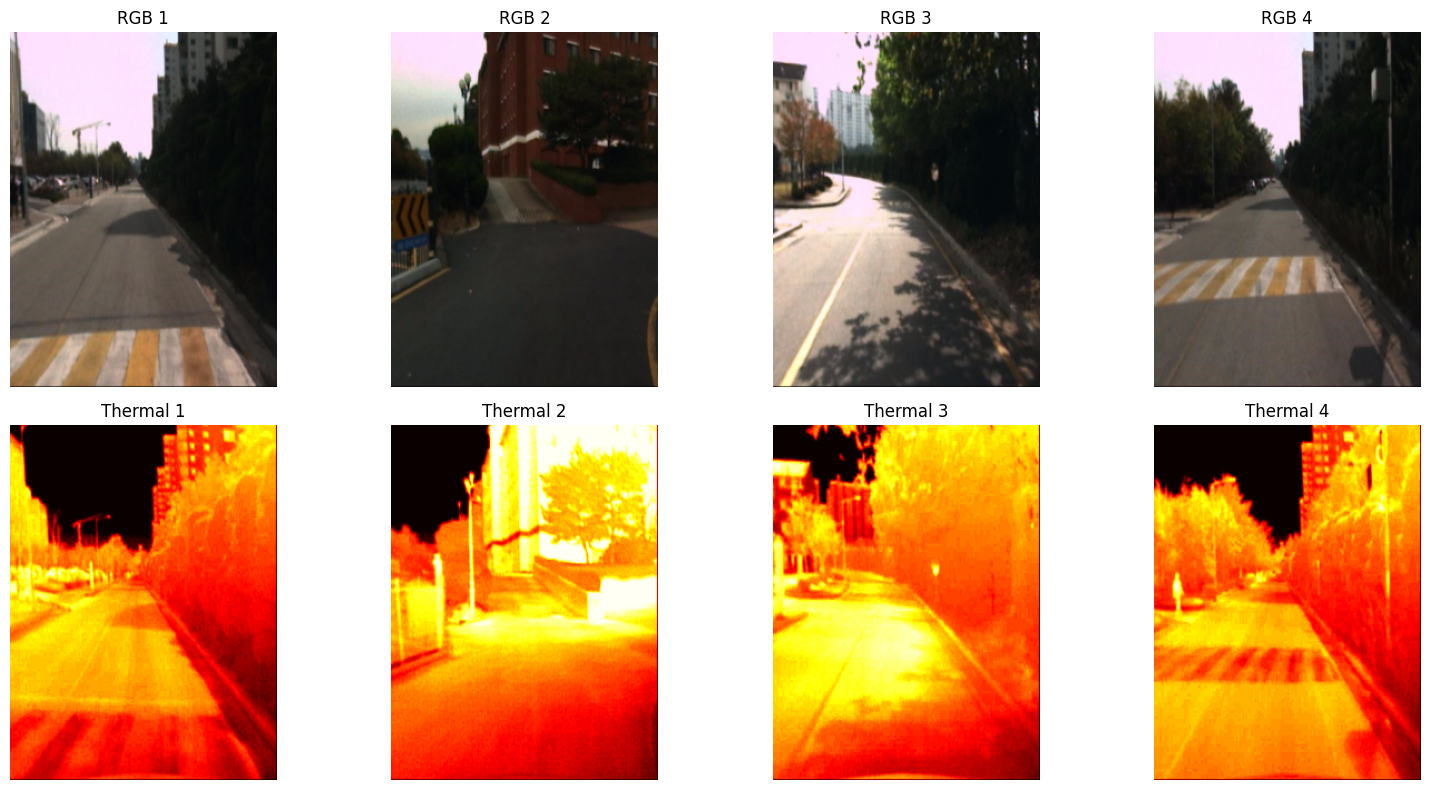

✓ Visualization saved!


In [15]:
import matplotlib.pyplot as plt

# Visualize some predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # RGB
    rgb_img = test_batch['rgb'][i].permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    rgb_img = np.clip(rgb_img, 0, 1)
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f'RGB {i+1}')
    axes[0, i].axis('off')

    # Thermal
    thermal_img = test_batch['thermal'][i].squeeze().cpu().numpy()
    axes[1, i].imshow(thermal_img, cmap='hot')
    axes[1, i].set_title(f'Thermal {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save to Drive
!cp results.png /content/drive/MyDrive/
print("✓ Visualization saved!")

In [16]:
# Cell: Download entire FINAL PROJECT folder

import os
from google.colab import files

# Navigate to the project directory
%cd /content/drive/MyDrive/Colab\ Notebooks/CV_Project

# Compress the entire FINAL PROJECT folder
!tar -czf FINAL_PROJECT_trained.tar.gz "FINAL PROJECT"

# Check the file size
!ls -lh FINAL_PROJECT_trained.tar.gz

# Download to your local machine
files.download('FINAL_PROJECT_trained.tar.gz')

print("✓ Download started! Check your browser's download folder.")

/content/drive/MyDrive/Colab Notebooks/CV_Project
tar: FINAL PROJECT/.gitignore: file changed as we read it
tar: FINAL PROJECT/Low-Light Pedestrian Risk Detection from Thermal.pdf: file changed as we read it
tar: FINAL PROJECT/README.md: file changed as we read it
tar: FINAL PROJECT/requirements_lite.txt: file changed as we read it
tar: FINAL PROJECT/requirements.txt: file changed as we read it
tar: FINAL PROJECT/setup.py: file changed as we read it
tar: FINAL PROJECT/configs/base.yaml: file changed as we read it
tar: FINAL PROJECT/data/README.md: file changed as we read it
tar: FINAL PROJECT/low_light_pedestrian_risk_detection.egg-info/dependency_links.txt: file changed as we read it
tar: FINAL PROJECT/low_light_pedestrian_risk_detection.egg-info/entry_points.txt: file changed as we read it
tar: FINAL PROJECT/low_light_pedestrian_risk_detection.egg-info/PKG-INFO: file changed as we read it
tar: FINAL PROJECT/low_light_pedestrian_risk_detection.egg-info/requires.txt: file changed as we

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started! Check your browser's download folder.
